# Data Analysis Interview Challenge

## Part 1 - EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
data_path = './logins.json'
df = pd.read_json(data_path)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# Aggregate these login counts based on 15-minute time intervals
df['login_time'] = pd.to_datetime(df['login_time'])
df = df.set_index('login_time')
df['count'] = 1
df = df.resample('15T').sum()
df.head(), df.tail()

(                     count
 login_time                
 1970-01-01 20:00:00      2
 1970-01-01 20:15:00      6
 1970-01-01 20:30:00      9
 1970-01-01 20:45:00      7
 1970-01-01 21:00:00      1,
                      count
 login_time                
 1970-04-13 17:45:00      5
 1970-04-13 18:00:00      5
 1970-04-13 18:15:00      2
 1970-04-13 18:30:00      7
 1970-04-13 18:45:00      6)

In [4]:
df.shape, df.describe()

((9788, 1),
              count
 count  9788.000000
 mean      9.515938
 std       8.328818
 min       0.000000
 25%       3.000000
 50%       7.000000
 75%      13.000000
 max      73.000000)

First I'll plot the entire series

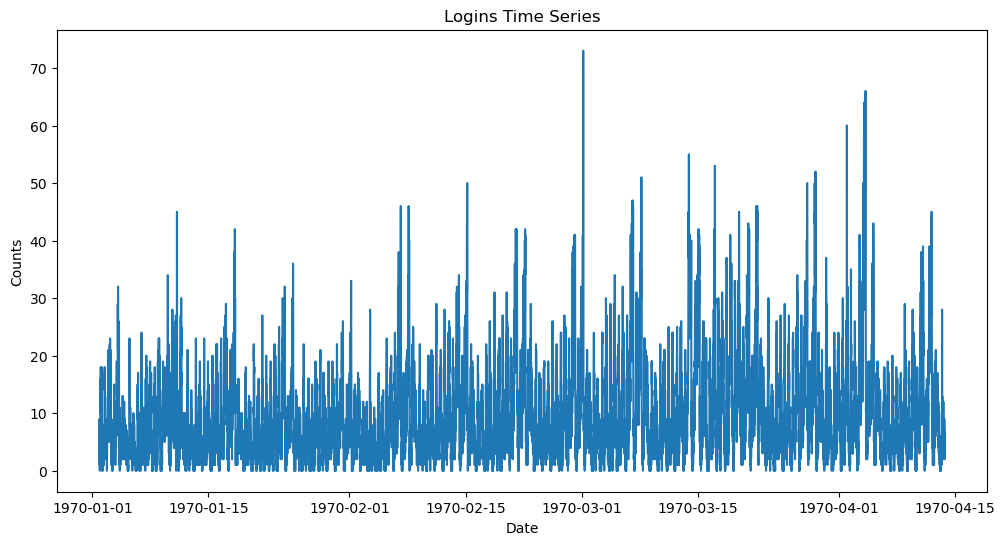

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='count')
plt.title('Logins Time Series')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.show()

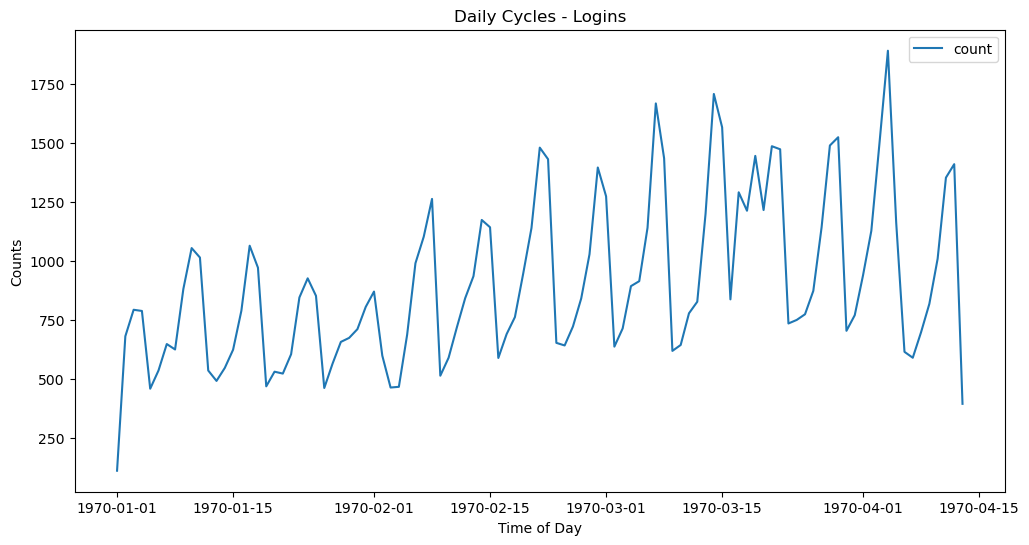

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.resample('D').sum())
plt.title('Daily Cycles - Logins')
plt.xlabel('Time of Day')
plt.ylabel('Counts')
plt.show()


Focusing on the average login rate by day shows a weekly pattern.

The weekly login rate slowly increases and peaks in the 12th week before decreasing.

In [7]:
# what day of week has the highest login count?
day_of_week = df.groupby(df.index.dayofweek).sum()
day_of_week.sort_values(by='count', ascending=False).head(2)

,count
login_time,
5,19377
6,18167


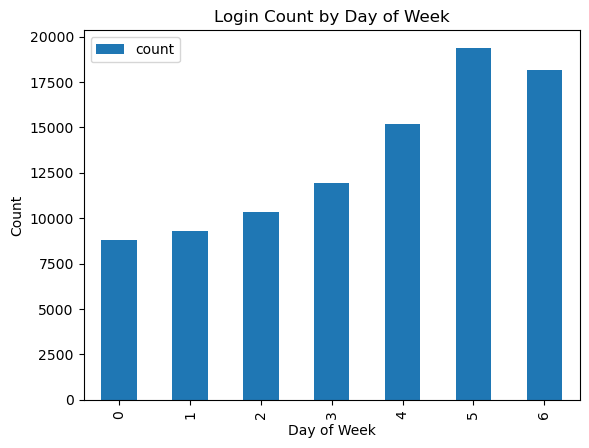

In [8]:
day_of_week.plot(kind='bar')
plt.xlabel('Day of Week')
# plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.xticks()
plt.ylabel('Count')
plt.title('Login Count by Day of Week')
plt.show()

The number of logins is higher during the weekend than the weekdays.

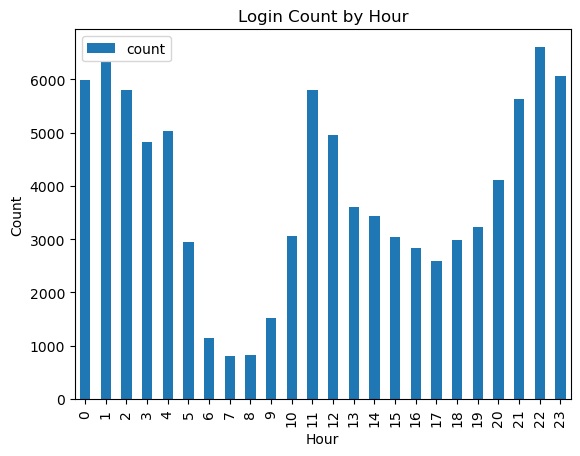

In [9]:
df.groupby(df.index.hour).sum().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Login Count by Hour')
plt.show()

There are two average peak times. Will investigate further.

In [10]:
# what range of hours in a day has the highest login count?
range_of_hours = df.groupby(df.index.hour).sum()
range_of_hours.sort_values(by='count', ascending=False).head()

,count
login_time,
22,6607
1,6317
23,6058
0,5993
2,5800


The average number of logins is higher during the night time than the day time.

In [11]:
# what range of hours in a day has the highest login count on the weekend?
weekend = df[df.index.dayofweek >= 5]
weekend.groupby(weekend.index.hour).sum().sort_values(by='count', ascending=False).head()

,count
login_time,
4,3826
3,3221
2,3216
1,2917
0,2377


The number of logins on weekends peaks between 12am and 5am.

In [12]:
# what range of hours in a day has the highest login count on the weekdays?
weekdays = df[df.index.dayofweek < 5]
weekdays.groupby(weekdays.index.hour).sum().sort_values(by='count', ascending=False).head()

,count
login_time,
11,5135
22,4862
23,4495
21,4124
12,3914


The number of logins on weekdays is peaks between 11am-12pm during the day and 9pm-11pm.

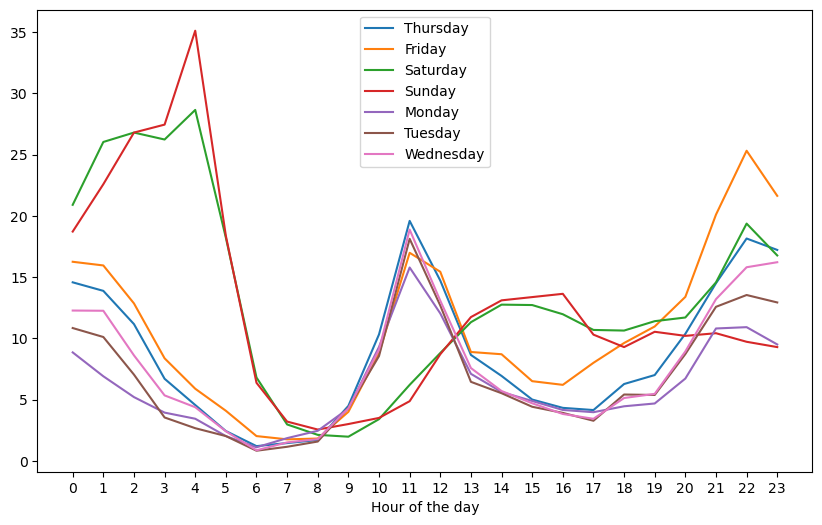

In [13]:
# Calculate the average hourly rate for each day of the week
grouped = df.groupby([df.index.day_name(), df.index.hour])

avg_hourly_rate = grouped.mean()

# Plot the average hourly rate for each day of the week on a single plot
fig, ax = plt.subplots(figsize=(10, 6))
for day in df.index.day_name().unique():
    ax.plot(avg_hourly_rate.loc[day], label=day)
ax.legend(loc='best')
ax.set_xlabel('Hour of the day')
ax.set_xticks(range(24))
plt.show()

# Part 2 - Experiment and Metric design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

> Seeing as the goal for reimbursing drivers is to incentivize them to serve customers in both cities, I would say the key measure of success would be an increase in total number of drivers serving both cities. Choosing this metric is appropriate as we can assess whether the toll reimbursement policy successfully motivates them to cross the bridge. 

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
- **a)** How you will implement the experiment

- **b)** what statistical test(s) you will conduct to verify the significance of the observation

- **c)** how you would interpret the results and provide the recommendations to the city operations team along with any caveats.

**a)**
To conduct the experiment, I need to define the null hypothesis (H0):
> The toll reimbursement policy has no effect on the number of driver partners serving both Gotham and Metropolis.

To implement the experiment, I would first collect all available data on the status of the current drivers. The most important would be recording the number of drivers serving both cities for a defined period before the introduction of the policy as this will serve as a baseline to compare against. I would also record which drivers opperated exclusive to one city and whether they operated on weekdays, weekends, or both.

**b)** The paired t-test can compare the change in number of drivers serving both cities before and after the policy implementation to check for statistical significance. 

The t-value measures the difference between the means relative to the variability within the samples, and the p-value indicates the statistical significance.


**c)**
- **Note**: it is important the analysis is conducted on both the weekdays and the weekends to assess the impact of the policy on different days of the week. 

- If the calculated p-value is less than the chosen significance level (typically 0.05), then I can reject the null hypothesis and conclude that the toll reimbursement policy has had a significant effet on the number of driver partners serving both cities. In this case, I would reccomend continuing with the toll reimbursement policy.

- Alternatively, if the p-value is greater, the null hypothesis can not be rejected indicating that there was not enough evidence to suggest the policy stay in effect. In this scenario, I would reccomend exploring alternative strategies or investigating other factors that influence the drivers' behaviors.

# Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1.  Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [14]:
data_path = './ultimate_data_challenge.json'
df = pd.read_json(data_path)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
df.shape

(50000, 12)

In [16]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


**1.** We defined a user as **retained** if they were _active_ in the 30 days before the data was pulled. To determine this, I will first make the assumption the data was pulled on the date of the latest `last_trip_date`. Then I will check to see which users were active in the preceeding 30 days.

In [18]:
# convert 'signup_date' and 'last_trip_date' columns to datetime objects
df['signup_date'], df['last_trip_date'] = pd.to_datetime(df['signup_date']), pd.to_datetime(df['last_trip_date'])

In [19]:
# Calculate the retention label
latest_date = df.last_trip_date.max()
df['retained'] = (latest_date - df.last_trip_date).dt.days <= 30

# Calculate the fraction of retained users
total_retained = df.retained.sum()

print("Fraction of retained users: {:.2%}".format(total_retained / len(df)))

Fraction of retained users: 37.61%


Now that we have the percentage of retained users, I will explore what factors are the best predictors for user retention. However, first I must handle any missing or duplicate values before any analysis can be done.

In [20]:
df[df.duplicated()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0,False
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0,False
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0,False
34641,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0,False
36627,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0,False
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0,False
42025,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0,False
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0,False


In [21]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [22]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8119
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

In terms of the missing data, it is difficult to determine which method of imputation is best without knowing the nature of the data loss. For example, the user may have not yet entered the review yet or the data might not have been collected properly.

I can assign those entries a 0, to indicate a missing review, but this could introduce bias and mislead the model. Alternatively, I can impute them using statistcal measures. 

To expedite the process and to avoid making any assumptions, I will opt to drop these entries for the time being.

In [31]:
# df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41440 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41440 non-null  object        
 1   trips_in_first_30_days  41440 non-null  int64         
 2   signup_date             41440 non-null  datetime64[ns]
 3   avg_rating_of_driver    41440 non-null  float64       
 4   avg_surge               41440 non-null  float64       
 5   last_trip_date          41440 non-null  datetime64[ns]
 6   phone                   41440 non-null  object        
 7   surge_pct               41440 non-null  float64       
 8   ultimate_black_user     41440 non-null  bool          
 9   weekday_pct             41440 non-null  float64       
 10  avg_dist                41440 non-null  float64       
 11  avg_rating_by_driver    41440 non-null  float64       
 12  retained                41440 non-null  bool  

In [40]:
df.signup_date.min() - df.last_trip_date.max()

Timedelta('-181 days +00:00:00')

When considering the target value for our predictive model, we want to determine whether a user will be active 6 mmonths after they first signed up. The dataset observations are over the span of 181 days. To determine if a user was  

In [ ]:
df['time_delta'] = (df['last_trip_date'] - df['signup_date']).dt.days